In [13]:
import os
import numpy as np 
import pandas as pd
import librosa
import pickle
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [14]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We create a function to Load the pickle file (pre_processed_data.pkl) which was created after data_extraction.
This file contains audio features: Mfccs, stfts (short time fourier transform) and mels (mel spectrograms) in the following format:


    data = {
        "semantic_label": [], ---> 'drilling', 'gun_shot', 'children_playing' etc
        "labels" : [],        --->  0000000001, 0000000010, ..and other one hot encoded labels
        "mfccs" : [],         --->  mfcc matrices of shape (44,13)
         "mels" : [],         --->  mel matrices of shape (44, 128)
         "stft" : []          --->  stft matrices of shape (44,1025)
          }
    
    
 

In [15]:
def load_data(filepath):
    with open(filepath, 'rb') as pkl_file:
        dataset = pickle.load(pkl_file)
        
    return dataset
    

We create a function to select a feature and also convert the selected feature to a numpy array

The features are : 'mels', 'stft', 'mfccs'

In this case, we are using Mfccs to train the model.However, other features can be used to train the model and best performing model can be selected



In [16]:
def select_feature(feature, filepath):
        
    dataset = load_data(filepath)
    
    f = dataset[feature]
        
    X = np.array(f)
    
    #add new axis to make 2d tensor 3d so that we can mimic image data which has 3 channels (RGB)
    
    X = X[...,np.newaxis]
    
    y = np.array(dataset['labels'])
    
    return X, y


X.shape, y.shape

((29300, 44, 13, 1), (29300, 10))

In [17]:
def prepare_datasets(test_size, validation_size):
    
     # load data
    
    filepath = '/content/drive/MyDrive/urbansound/dataset.pkl'
    
    #select feature

    X, y = select_feature('mfccs', filepath)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)


    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [18]:
def build_model(input_shape):

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(256, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [19]:
def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """


    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [20]:
if __name__ == '__main__':
         # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 42, 11, 64)        640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 6, 64)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 21, 6, 64)         256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 19, 4, 128)        73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 2, 128)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 10, 2, 128)        512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 1, 256)        

In [21]:
if __name__=='__main__':
    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=64, epochs=100)

  

Epoch 1/100
275/275 [==============================] - 2s 5ms/step - loss: 1.6544 - accuracy: 0.4677 - val_loss: 0.9984 - val_accuracy: 0.6648
Epoch 2/100
275/275 [==============================] - 1s 5ms/step - loss: 0.8801 - accuracy: 0.7086 - val_loss: 0.6762 - val_accuracy: 0.7741
Epoch 3/100
275/275 [==============================] - 1s 5ms/step - loss: 0.7119 - accuracy: 0.7646 - val_loss: 0.5993 - val_accuracy: 0.8064
Epoch 4/100
275/275 [==============================] - 1s 5ms/step - loss: 0.5898 - accuracy: 0.7992 - val_loss: 0.5568 - val_accuracy: 0.8068
Epoch 5/100
275/275 [==============================] - 1s 5ms/step - loss: 0.5070 - accuracy: 0.8322 - val_loss: 0.4769 - val_accuracy: 0.8391
Epoch 6/100
275/275 [==============================] - 1s 5ms/step - loss: 0.4529 - accuracy: 0.8480 - val_loss: 0.4263 - val_accuracy: 0.8491
Epoch 7/100
275/275 [==============================] - 1s 5ms/step - loss: 0.4017 - accuracy: 0.8635 - val_loss: 0.4423 - val_accuracy: 0.8512

In [22]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="Validation accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    print()
    print()

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

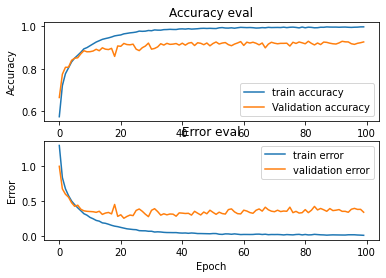



229/229 - 0s - loss: 0.3307 - accuracy: 0.9279



Test accuracy: 0.9279180765151978


In [23]:
if __name__ == '__main__':
  plot_history(history)
  print()
  print()
  test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
  print()
  print()
  print('\nTest accuracy:', test_acc)

In [26]:
if __name__ == '__main__':
    # pick a sample to predict from the test set
    X_to_predict = X_test[101]
    y_to_predict = y_test[108]

   

    # predict sample
    predict(model, X_to_predict, y_to_predict)
  

Target: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], Predicted label: [0]
